In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Generate Synthetic Data

In [2]:
# Physics parameters
g = 9.8        # acceleration due to gravity
h0 = 1.0       # initial height
v0 = 10.0      # initial velocity

# True (analytical) solution h(t) = h0 + v0*t - 0.5*g*t^2
def true_solution(t):
    return h0 + v0*t - 0.5*g*(t**2)

In [3]:
# Generate some time points
t_min, t_max = 0.0, 2.0
N_data = 10
t_data = np.linspace(t_min, t_max, N_data)

# Generate synthetic "experimental" heights with noise
np.random.seed(0)
noise_level = 0.3
h_data_exact = true_solution(t_data)
h_data_noisy = h_data_exact + noise_level*np.random.randn(N_data)

# Convert to PyTorch tensors
t_data_tensor = torch.tensor(t_data, dtype=torch.float32).view(-1, 1)
h_data_tensor = torch.tensor(h_data_noisy, dtype=torch.float32).view(-1, 1)

### 2. Define a small feed-forward neural network for h(t)

In [5]:
class PINN(nn.Module):
    def __init__(self, n_hidden=20):
        super(PINN, self).__init__()
        # A simple MLP with 2 hidden layers
        self.net = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, t):
        """
        Forward pass: input shape (batch_size, 1) -> output shape (batch_size, 1)
        """
        return self.net(t)

# Instantiate the model
model = PINN(n_hidden=20)

### 3. Helper for Automatic Diff

In [6]:
def derivative(y, x):
    """
    Computes dy/dx using PyTorch's autograd.
    y and x must be tensors with requires_grad=True for x.
    """
    return torch.autograd.grad(
        y, x,
        grad_outputs=torch.ones_like(y),
        create_graph=True
    )[0]

### 4. Define the Loss Components (PINN)

-    (1) Data loss (fit noisy data)
-    (2) ODE loss: dh/dt = v0 - g * t
-    (3) Initial condition loss: h(0) = h0


In [7]:
def data_loss(model, t_data, h_data):
    """
    MSE between predicted h(t_i) and noisy measurements h_data.
    """
    h_pred = model(t_data)
    return torch.mean((h_pred - h_data)**2)

def physics_loss(model, t):
    """
    Compare d(h_pred)/dt with the known expression (v0 - g t).
    """
    # t must have requires_grad = True for autograd to work
    t.requires_grad_(True)

    h_pred = model(t)
    dh_dt_pred = derivative(h_pred, t)

    # For each t, physics says dh/dt = v0 - g * t
    dh_dt_true = v0 - g * t

    loss_ode = torch.mean((dh_dt_pred - dh_dt_true)**2)
    return loss_ode

def initial_condition_loss(model):
    """
    Enforce h(0) = h0.
    """
    # Evaluate at t=0
    t0 = torch.zeros(1, 1, dtype=torch.float32, requires_grad=False)
    h0_pred = model(t0)
    return (h0_pred - h0).pow(2).mean()

### 5. Training Setup

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Hyperparameters for weighting the loss terms
lambda_data = 2.0
lambda_ode  = 2.0
lambda_ic   = 2.0

# For logging
num_epochs = 4000
print_every = 200

### 6. Training Loop

In [10]:
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Compute losses
    l_data = data_loss(model, t_data_tensor, h_data_tensor)
    l_ode  = physics_loss(model, t_data_tensor)
    l_ic   = initial_condition_loss(model)

    # Combined loss
    loss = lambda_data * l_data + lambda_ode * l_ode + lambda_ic * l_ic

    # Backprop
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % print_every == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Total Loss = {loss.item():.6f}, "
              f"Data Loss = {l_data.item():.6f}, "
              f"ODE Loss = {l_ode.item():.6f}, "
              f"IC Loss = {l_ic.item():.6f}")

Epoch 200/4000, Total Loss = 0.212508, Data Loss = 0.089216, ODE Loss = 0.014203, IC Loss = 0.002836
Epoch 400/4000, Total Loss = 0.200787, Data Loss = 0.088255, ODE Loss = 0.009292, IC Loss = 0.002846
Epoch 600/4000, Total Loss = 0.193636, Data Loss = 0.088468, ODE Loss = 0.005729, IC Loss = 0.002621
Epoch 800/4000, Total Loss = 0.190453, Data Loss = 0.088280, ODE Loss = 0.004416, IC Loss = 0.002530
Epoch 1000/4000, Total Loss = 0.189134, Data Loss = 0.088112, ODE Loss = 0.003962, IC Loss = 0.002492
Epoch 1200/4000, Total Loss = 0.188597, Data Loss = 0.087943, ODE Loss = 0.003881, IC Loss = 0.002474
Epoch 1400/4000, Total Loss = 0.188271, Data Loss = 0.087771, ODE Loss = 0.003896, IC Loss = 0.002468
Epoch 1600/4000, Total Loss = 0.187985, Data Loss = 0.087602, ODE Loss = 0.003925, IC Loss = 0.002465
Epoch 1800/4000, Total Loss = 0.187706, Data Loss = 0.087435, ODE Loss = 0.003956, IC Loss = 0.002463
Epoch 2000/4000, Total Loss = 0.187420, Data Loss = 0.087263, ODE Loss = 0.003989, IC 

### 7. Evaluate the Trained Model

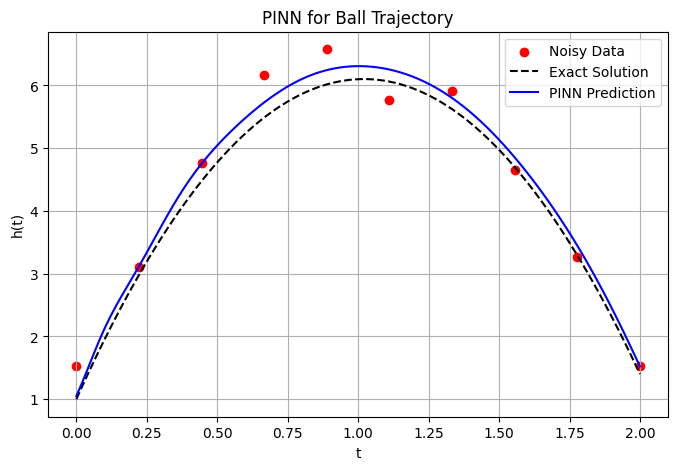

In [11]:
model.eval()
t_plot = np.linspace(t_min, t_max, 100).reshape(-1, 1).astype(np.float32)
t_plot_tensor = torch.tensor(t_plot, requires_grad=True)
h_pred_plot = model(t_plot_tensor).detach().numpy()

# True solution (for comparison)
h_true_plot = true_solution(t_plot)

# Plot results
plt.figure(figsize=(8, 5))
plt.scatter(t_data, h_data_noisy, color='red', label='Noisy Data')
plt.plot(t_plot, h_true_plot, 'k--', label='Exact Solution')
plt.plot(t_plot, h_pred_plot, 'b', label='PINN Prediction')
plt.xlabel('t')
plt.ylabel('h(t)')
plt.legend()
plt.title('PINN for Ball Trajectory')
plt.grid(True)
plt.show()